# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

#### Признаки
DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
#### Целевой признак
* Price — цена (евро)

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm

from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler



RS = 33564 #Random Seed

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [3]:
# функция для ознакомления с данными

def first_look(data):
    display(data.info())
    print()
    display(data.describe())
    print()
    print('Дубликатов обнаружено: ', data.duplicated().sum())
    print()
    data.hist(figsize=(25, 15))
    plt.show()
    print()
    print('Размер датасета:', data.shape)
    print()
    print('Пропуски')
    print(data.isna().sum())
    display(data.sample(40))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Дубликатов обнаружено:  4



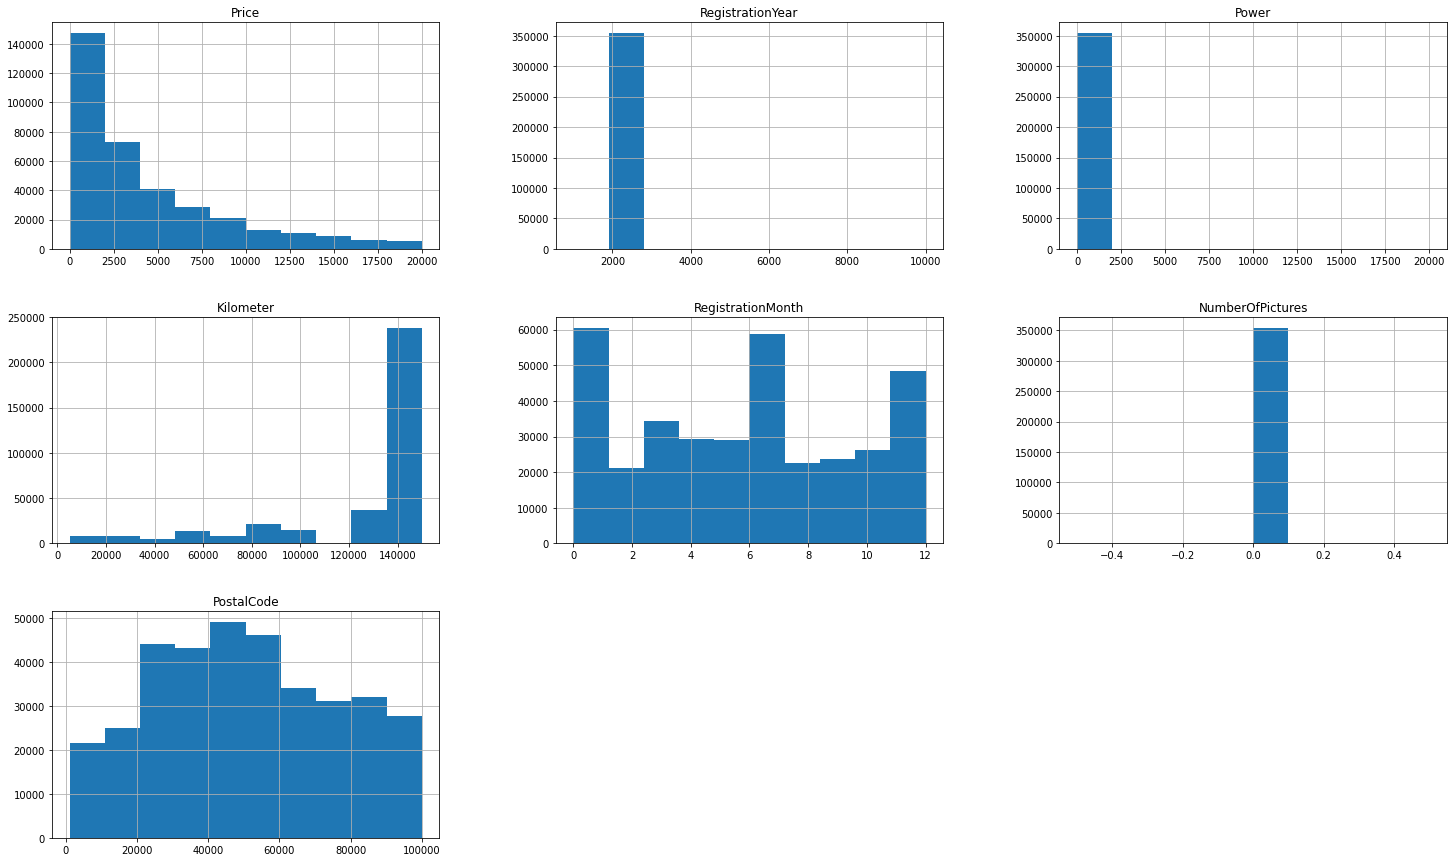


Размер датасета: (354369, 16)

Пропуски
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
225811,2016-03-31 17:48:19,799,NaN,2016,auto,0,fortwo,100000,0,NaN,smart,NaN,2016-03-31 00:00:00,0,81375,2016-03-31 17:48:19
335034,2016-03-20 18:47:47,4600,sedan,2004,manual,115,3er,125000,11,petrol,bmw,no,2016-03-20 00:00:00,0,66740,2016-04-07 02:18:04
215550,2016-03-30 22:30:52,2499,wagon,2000,manual,150,3er,150000,1,petrol,bmw,no,2016-03-30 00:00:00,0,61250,2016-04-05 14:16:44
37605,2016-03-18 11:48:26,400,sedan,1997,manual,0,3er,150000,0,NaN,bmw,yes,2016-03-18 00:00:00,0,84160,2016-04-01 23:48:32
101510,2016-03-26 22:37:59,500,NaN,2016,manual,107,laguna,150000,4,petrol,renault,no,2016-03-26 00:00:00,0,97762,2016-03-27 00:43:02
307121,2016-03-26 17:58:01,6900,small,2011,manual,86,polo,150000,2,petrol,volkswagen,no,2016-03-26 00:00:00,0,63450,2016-04-06 07:45:00
135135,2016-03-25 13:56:06,6300,other,1999,manual,209,other,150000,7,petrol,audi,NaN,2016-03-25 00:00:00,0,59075,2016-04-02 17:17:35
100589,2016-03-26 23:56:50,200,small,1998,manual,90,fiesta,150000,0,petrol,ford,NaN,2016-03-26 00:00:00,0,50189,2016-03-30 12:18:06
188094,2016-04-03 21:58:40,14999,NaN,2018,manual,211,NaN,90000,9,NaN,volkswagen,no,2016-04-03 00:00:00,0,99198,2016-04-05 23:45:40
4915,2016-04-03 18:50:34,2400,sedan,2004,NaN,0,a3,150000,10,gasoline,audi,NaN,2016-04-03 00:00:00,0,51065,2016-04-03 18:50:34


In [4]:
first_look(data)

In [5]:
# Сразу удалим дубликаты

data.drop_duplicates(inplace=True)

In [6]:
data = data.rename(columns=
    {'DateCrawled': 'date_crawled',
     'Price': 'price',
     'VehicleType': 'vehicle_type',
     'RegistrationYear': 'registration_year',
     'Gearbox': 'gearbox',
     'Power': 'power',
     'Model': 'model',
     'Kilometer': 'kilometer',
     'RegistrationMonth': 'registration_month',
     'FuelType': 'fuel_type',
     'Brand': 'brand',
     'Repaired': 'repaired', 
     'DateCreated': 'date_created',
     'NumberOfPictures': 'number_of_pictures',
     'PostalCode': 'postal_code',
     'LastSeen': 'last_seen'
    }
)

In [7]:
# Отбросим время, оставим дату в столбцах с датами

data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S').dt.round('1d')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S').dt.round('1d')

data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S').dt.round('1d')


In [8]:
# Переставим колонки в более логичном виде

data = data[
    ['date_created', 'date_crawled', 'last_seen', 
    'brand', 'model', 'vehicle_type', 'fuel_type', 'gearbox', 'power', 'kilometer', 
       'registration_year', 'registration_month', 'repaired',
       'number_of_pictures', 'postal_code',
       'price']
       ]

In [9]:
data.head()

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
0,2016-03-24,2016-03-24,2016-04-07,volkswagen,golf,NaN,petrol,manual,0,150000,1993,0,NaN,0,70435,480
1,2016-03-24,2016-03-24,2016-04-07,audi,NaN,coupe,gasoline,manual,190,125000,2011,5,yes,0,66954,18300
2,2016-03-14,2016-03-15,2016-04-06,jeep,grand,suv,gasoline,auto,163,125000,2004,8,NaN,0,90480,9800
3,2016-03-17,2016-03-18,2016-03-18,volkswagen,golf,small,petrol,manual,75,150000,2001,6,no,0,91074,1500
4,2016-03-31,2016-04-01,2016-04-06,skoda,fabia,small,gasoline,manual,69,90000,2008,7,no,0,60437,3600


In [10]:
# Скачано раньше, чем создано
data[data['date_created'] > data['date_crawled']].shape[0]

0

In [11]:
# Просмотрено раньше, чем создано
data[data['date_created'] > data['last_seen']].shape[0]

0

In [12]:
# Создано раньше, чем машина зарегистрирована
data[data['registration_year'] > data['date_created'].dt.year].shape[0]

14530

In [13]:
data[data['registration_year'] > data['date_created'].dt.year]

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
22,2016-03-23,2016-03-24,2016-03-31,opel,meriva,NaN,petrol,manual,90,150000,2018,5,no,0,49716,2900
26,2016-03-10,2016-03-11,2016-03-16,citroen,c4,NaN,NaN,manual,125,125000,2017,4,no,0,31139,5555
48,2016-03-25,2016-03-26,2016-04-01,volkswagen,golf,NaN,petrol,manual,80,100000,2017,1,NaN,0,48499,7750
51,2016-03-07,2016-03-08,2016-03-08,fiat,punto,NaN,gasoline,manual,90,150000,2017,11,yes,0,66115,2000
57,2016-03-10,2016-03-11,2016-03-25,seat,other,NaN,NaN,manual,64,125000,2018,3,no,0,33397,2399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11,2016-03-12,2016-03-12,ford,transit,NaN,gasoline,manual,86,150000,2017,5,NaN,0,32339,3600
354140,2016-03-29,2016-03-30,2016-04-06,audi,a4,NaN,NaN,manual,101,150000,2017,9,NaN,0,38315,1000
354203,2016-03-17,2016-03-17,2016-03-30,ford,fiesta,NaN,NaN,manual,80,150000,2018,6,no,0,44866,2140
354253,2016-03-25,2016-03-25,2016-04-06,opel,corsa,NaN,petrol,NaN,0,150000,2018,0,NaN,0,45527,1250


In [14]:
data = data[data['registration_year'] <= data['date_created'].dt.year]

In [15]:
data.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'land_rover', 'lada'], dtype=object)

In [16]:
data.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',


In [17]:
# Поскольку модель-NaN определить не можем, заполним как other
data.model.fillna('other', inplace=True)


In [18]:
data.vehicle_type.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [19]:
data[data.vehicle_type.isna()]

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
0,2016-03-24,2016-03-24,2016-04-07,volkswagen,golf,NaN,petrol,manual,0,150000,1993,0,NaN,0,70435,480
16,2016-04-01,2016-04-02,2016-04-02,volkswagen,polo,NaN,petrol,NaN,60,150000,2016,0,NaN,0,38871,300
31,2016-03-29,2016-03-30,2016-03-30,renault,clio,NaN,petrol,manual,60,150000,2016,6,NaN,0,37075,899
35,2016-03-08,2016-03-08,2016-03-08,volkswagen,golf,NaN,petrol,manual,75,150000,2016,4,no,0,19386,350
37,2016-03-28,2016-03-29,2016-03-30,renault,kangoo,NaN,gasoline,NaN,0,150000,2016,1,no,0,46483,1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07,2016-03-08,2016-03-09,mercedes_benz,c_klasse,NaN,NaN,auto,0,150000,2005,9,NaN,0,61169,2600
354351,2016-03-11,2016-03-12,2016-03-13,volkswagen,other,NaN,NaN,manual,110,150000,2000,7,no,0,87700,1900
354361,2016-03-09,2016-03-10,2016-03-13,alfa_romeo,159,NaN,NaN,auto,150,150000,2016,12,no,0,51371,5250
354364,2016-03-21,2016-03-21,2016-03-21,mitsubishi,colt,NaN,petrol,manual,0,150000,2005,7,yes,0,2694,0


In [20]:
data.vehicle_type.isna().sum()

22980

In [22]:
data['vehicle_type'] = data['vehicle_type'].fillna(data.groupby(by=['brand', 'model'])['vehicle_type'].transform(lambda x: x.value_counts().idxmax()))
data['fuel_type'] = data['fuel_type'].fillna(data.groupby(by=['brand', 'model'])['fuel_type'].transform(lambda x: x.value_counts().idxmax()))
data['gearbox'] = data['gearbox'].fillna(data.groupby(by=['brand', 'model'])['gearbox'].transform(lambda x: x.value_counts().idxmax()))


data.isna().sum()

date_created              0
date_crawled              0
last_seen                 0
brand                     0
model                     0
vehicle_type              0
fuel_type                 0
gearbox                   0
power                     0
kilometer                 0
registration_year         0
registration_month        0
repaired              64855
number_of_pictures        0
postal_code               0
price                     0
dtype: int64

In [24]:
# Тип топлива требует унификации

data['fuel_type'].replace(
    {'petrol': 'oil', 
    'gasoline': 'oil', # оба - бензин
    'lpg': 'gas', # lpg и cng - пропан и метан соответственно
    'other': 'other',
    'hybrid': 'hybrid',
    'cng': 'gas',
    'electric': 'electric'

    }, inplace=True
)

In [25]:
# Считаем, что отсутствие пометки о ремонтах есть отсутствие ремонтов
data.repaired.fillna('no', inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339835 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_created        339835 non-null  datetime64[ns]
 1   date_crawled        339835 non-null  datetime64[ns]
 2   last_seen           339835 non-null  datetime64[ns]
 3   brand               339835 non-null  object        
 4   model               339835 non-null  object        
 5   vehicle_type        339835 non-null  object        
 6   fuel_type           339835 non-null  object        
 7   gearbox             339835 non-null  object        
 8   power               339835 non-null  int64         
 9   kilometer           339835 non-null  int64         
 10  registration_year   339835 non-null  int64         
 11  registration_month  339835 non-null  int64         
 12  repaired            339835 non-null  object        
 13  number_of_pictures  339835 no

In [27]:
data.duplicated().sum()

7632

In [28]:
data[data.duplicated(keep=False)].sort_values(by=['brand', 'model'], ascending=False)

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
34426,2016-03-27,2016-03-28,2016-03-28,volvo,xc_reihe,suv,oil,auto,185,90000,2008,1,no,0,60311,8000
40929,2016-03-09,2016-03-10,2016-03-10,volvo,xc_reihe,suv,oil,auto,185,90000,2008,1,no,0,10115,10000
42845,2016-03-26,2016-03-27,2016-04-06,volvo,xc_reihe,suv,oil,auto,163,150000,2003,3,no,0,51375,9999
67620,2016-03-16,2016-03-17,2016-03-17,volvo,xc_reihe,suv,oil,auto,185,90000,2008,1,no,0,10115,10000
74799,2016-03-13,2016-03-14,2016-03-14,volvo,xc_reihe,suv,oil,auto,185,90000,2008,1,no,0,10115,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319438,2016-03-31,2016-04-01,2016-04-07,alfa_romeo,147,sedan,oil,manual,105,80000,2009,8,no,0,90537,5499
348900,2016-04-02,2016-04-02,2016-04-04,alfa_romeo,147,sedan,oil,manual,120,150000,2007,4,no,0,86678,3450
352757,2016-03-20,2016-03-21,2016-04-06,alfa_romeo,147,sedan,oil,manual,120,100000,2007,3,no,0,92339,3333
68907,2016-04-03,2016-04-04,2016-04-04,alfa_romeo,145,small,oil,manual,103,90000,2000,12,no,0,86368,2200


In [29]:
# И еще раз удалим дубликаты

data.drop_duplicates(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332203 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_created        332203 non-null  datetime64[ns]
 1   date_crawled        332203 non-null  datetime64[ns]
 2   last_seen           332203 non-null  datetime64[ns]
 3   brand               332203 non-null  object        
 4   model               332203 non-null  object        
 5   vehicle_type        332203 non-null  object        
 6   fuel_type           332203 non-null  object        
 7   gearbox             332203 non-null  object        
 8   power               332203 non-null  int64         
 9   kilometer           332203 non-null  int64         
 10  registration_year   332203 non-null  int64         
 11  registration_month  332203 non-null  int64         
 12  repaired            332203 non-null  object        
 13  number_of_pictures  332203 no

None

,power,kilometer,registration_year,registration_month,number_of_pictures,postal_code,price
count,332203.000000,332203.000000,332203.000000,332203.000000,332203.0,332203.000000,332203.000000
mean,110.869143,128100.814863,2002.303784,5.746369,0.0,50626.368922,4455.457118
std,187.982520,37935.610487,14.070458,3.711496,0.0,25811.217495,4542.506328
min,0.000000,5000.000000,1000.000000,0.000000,0.0,1067.000000,0.000000
25%,69.000000,125000.000000,1999.000000,3.000000,0.0,30169.000000,1050.000000
50%,105.000000,150000.000000,2003.000000,6.000000,0.0,49497.000000,2750.000000
75%,143.000000,150000.000000,2007.000000,9.000000,0.0,71263.000000,6499.000000
max,20000.000000,150000.000000,2016.000000,12.000000,0.0,99998.000000,20000.000000



Дубликатов обнаружено:  0



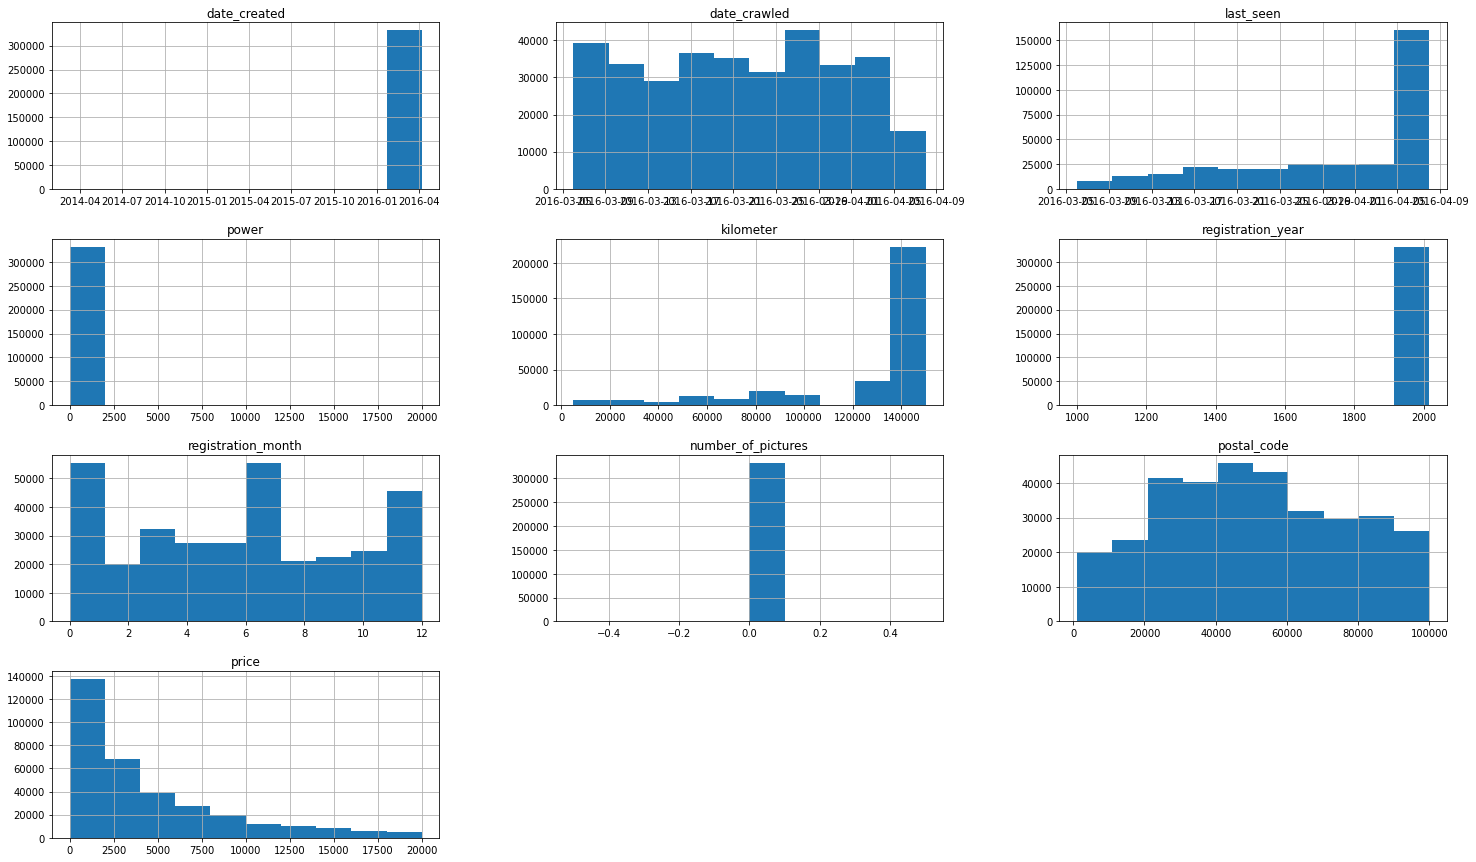


Размер датасета: (332203, 16)

Пропуски
date_created          0
date_crawled          0
last_seen             0
brand                 0
model                 0
vehicle_type          0
fuel_type             0
gearbox               0
power                 0
kilometer             0
registration_year     0
registration_month    0
repaired              0
number_of_pictures    0
postal_code           0
price                 0
dtype: int64


,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
188315,2016-03-19,2016-03-20,2016-03-23,peugeot,1_reihe,small,oil,manual,68,125000,2007,1,no,0,60438,2700
200920,2016-03-16,2016-03-17,2016-04-06,opel,vectra,sedan,oil,manual,116,150000,1997,1,no,0,39397,800
81226,2016-04-04,2016-04-04,2016-04-06,bmw,5er,wagon,oil,auto,177,150000,2004,6,no,0,8118,6800
80505,2016-03-08,2016-03-09,2016-03-13,alfa_romeo,147,sedan,oil,manual,150,150000,2005,3,yes,0,31787,1500
317099,2016-04-01,2016-04-02,2016-04-07,opel,vectra,wagon,oil,manual,155,150000,2004,4,no,0,39130,3200
154013,2016-03-08,2016-03-09,2016-03-14,bmw,1er,sedan,oil,manual,115,150000,2006,1,no,0,44653,5499
14670,2016-03-10,2016-03-11,2016-03-13,mitsubishi,lancer,wagon,oil,manual,0,150000,2000,2,no,0,79100,950
239468,2016-03-20,2016-03-21,2016-04-07,hyundai,other,coupe,oil,manual,136,150000,2003,6,no,0,51702,2900
242820,2016-04-07,2016-04-07,2016-04-07,audi,a6,sedan,oil,auto,150,150000,1996,4,no,0,61267,1299
24220,2016-03-24,2016-03-25,2016-03-25,mercedes_benz,clk,coupe,oil,manual,163,150000,2000,12,no,0,26419,1850


In [30]:
first_look(data)

In [31]:
# Слишком большие значения мощности

data.query('power > 500')

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
1816,2016-03-22,2016-03-23,2016-03-23,toyota,corolla,small,oil,manual,1398,5000,2004,6,no,0,22043,3200
2102,2016-03-21,2016-03-21,2016-04-04,opel,vectra,sedan,oil,manual,1799,150000,1999,1,yes,0,1723,0
4060,2016-04-03,2016-04-04,2016-04-08,mitsubishi,colt,sedan,oil,manual,953,150000,2005,4,no,0,60326,3100
5328,2016-03-29,2016-03-30,2016-04-06,opel,astra,wagon,oil,manual,1001,150000,1999,7,no,0,33154,500
6296,2016-03-31,2016-04-01,2016-04-01,chevrolet,matiz,small,oil,manual,603,5000,2002,11,yes,0,44379,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348830,2016-03-21,2016-03-22,2016-04-06,sonstige_autos,other,sedan,oil,manual,1000,150000,1000,0,no,0,41472,1
348883,2016-03-13,2016-03-13,2016-04-07,renault,scenic,sedan,oil,manual,1548,90000,2011,4,no,0,24568,7500
348968,2016-04-04,2016-04-05,2016-04-05,lancia,ypsilon,small,oil,manual,1241,150000,1999,5,yes,0,28259,250
351947,2016-03-07,2016-03-08,2016-03-10,opel,zafira,bus,oil,manual,1001,5000,2001,7,no,0,66117,1500


In [32]:
# Вероятнее всего, пропущена десятичная точка. Уменьшим в 10 раз

data.loc[data['power'] > 500, 'power'] = (data.loc[data['power'] > 500, 'power'] / 10).astype('int64')

In [33]:
data.query('power > 500')

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
7661,2016-04-02,2016-04-03,2016-04-06,volkswagen,lupo,small,oil,manual,751,150000,1999,4,no,0,65830,1499
11039,2016-03-25,2016-03-26,2016-04-02,fiat,other,sedan,oil,manual,1031,150000,1998,8,no,0,57520,0
25232,2016-03-28,2016-03-29,2016-04-07,volkswagen,caddy,bus,oil,manual,1052,150000,2009,6,no,0,36272,10900
33952,2016-03-09,2016-03-09,2016-03-17,toyota,aygo,small,oil,manual,692,90000,2006,10,no,0,94116,3740
44520,2016-03-10,2016-03-11,2016-04-06,volkswagen,golf,convertible,oil,manual,751,150000,1998,6,no,0,68239,2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328862,2016-03-20,2016-03-20,2016-04-04,opel,corsa,small,oil,manual,850,150000,2000,3,no,0,26721,850
339642,2016-03-07,2016-03-08,2016-03-08,ford,focus,sedan,oil,manual,1011,125000,2000,12,no,0,35066,600
341320,2016-03-29,2016-03-30,2016-04-01,citroen,berlingo,other,oil,manual,751,125000,2006,11,yes,0,89428,1899
346639,2016-03-25,2016-03-26,2016-04-07,mitsubishi,carisma,sedan,oil,manual,1251,150000,2000,9,no,0,42105,1300


In [34]:
# И еще раз, для тех строк, где после запятой было 2 знака

data.loc[data['power'] > 500, 'power'] = (data.loc[data['power'] > 500, 'power'] / 10).astype('int64')

In [35]:
data.query('power == 0')

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
0,2016-03-24,2016-03-24,2016-04-07,volkswagen,golf,sedan,oil,manual,0,150000,1993,0,no,0,70435,480
15,2016-03-11,2016-03-12,2016-03-19,ford,ka,small,oil,manual,0,5000,1910,0,no,0,24148,450
32,2016-03-15,2016-03-16,2016-03-18,volkswagen,golf,sedan,oil,manual,0,150000,1994,2,no,0,44145,245
37,2016-03-28,2016-03-29,2016-03-30,renault,kangoo,bus,oil,manual,0,150000,2016,1,no,0,46483,1500
40,2016-03-26,2016-03-27,2016-03-28,opel,corsa,small,oil,manual,0,150000,1990,1,no,0,56412,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31,2016-04-01,2016-04-07,opel,other,small,oil,manual,0,125000,1995,3,no,0,41470,180
354346,2016-03-07,2016-03-08,2016-03-09,mercedes_benz,c_klasse,sedan,oil,auto,0,150000,2005,9,no,0,61169,2600
354363,2016-03-27,2016-03-28,2016-03-29,opel,zafira,bus,oil,manual,0,150000,2000,3,no,0,26624,1150
354364,2016-03-21,2016-03-21,2016-03-21,mitsubishi,colt,sedan,oil,manual,0,150000,2005,7,yes,0,2694,0


In [37]:
data.loc[data[data.power == 0].index, 'power'] = data.groupby(by=['brand', 'model'])['power'].transform('median').loc[data[data.power == 0].index]


data.loc[data[data.power == 0].index, 'power'] = data.groupby(by=['brand'])['power'].transform('median').loc[data[data.power == 0].index]


In [38]:
data.query('power == 0')

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price


In [39]:
data[data.registration_year < 1950].sort_values(by='kilometer')

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
15,2016-03-11,2016-03-12,2016-03-19,ford,ka,small,oil,manual,60.0,5000,1910,0,no,0,24148,450
193266,2016-03-13,2016-03-14,2016-03-14,sonstige_autos,other,sedan,oil,manual,50.0,5000,1910,0,no,0,1454,0
195144,2016-03-25,2016-03-26,2016-04-07,land_rover,defender,suv,oil,manual,122.0,5000,1000,0,no,0,57072,25
195855,2016-03-28,2016-03-29,2016-04-05,opel,zafira,bus,oil,manual,120.0,5000,1800,0,no,0,50171,1
199752,2016-03-31,2016-04-01,2016-04-03,sonstige_autos,other,sedan,oil,manual,50.0,5000,1910,1,no,0,80469,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87717,2016-03-14,2016-03-14,2016-03-14,sonstige_autos,other,bus,oil,manual,50.0,150000,1910,12,no,0,49324,1
29516,2016-03-22,2016-03-22,2016-03-28,fiat,punto,small,oil,manual,60.0,150000,1910,0,no,0,92637,80
88033,2016-03-29,2016-03-30,2016-04-06,jeep,other,suv,oil,manual,72.0,150000,1942,2,no,0,63925,6999
35943,2016-03-19,2016-03-19,2016-03-21,volkswagen,caddy,other,oil,manual,90.0,150000,1910,0,no,0,35096,200


In [40]:
# Машины даже с пробегом в 150к возрастом 50+ лет? К тому же явные неточности в данных - к примеру, VW Caddy выпускается с 1980 года. Удалим от греха подальше

data = data[data.registration_year > 1950]

In [41]:
data.query('registration_month == 0')

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,registration_month,repaired,number_of_pictures,postal_code,price
0,2016-03-24,2016-03-24,2016-04-07,volkswagen,golf,sedan,oil,manual,98.0,150000,1993,0,no,0,70435,480
9,2016-03-17,2016-03-17,2016-04-01,volkswagen,golf,small,oil,manual,101.0,150000,1998,0,no,0,27472,999
16,2016-04-01,2016-04-02,2016-04-02,volkswagen,polo,small,oil,manual,60.0,150000,2016,0,no,0,38871,300
36,2016-03-11,2016-03-11,2016-04-07,opel,kadett,other,oil,manual,75.0,70000,1991,0,no,0,2943,1600
54,2016-03-17,2016-03-17,2016-04-04,opel,signum,wagon,oil,manual,155.0,150000,2005,0,no,0,88433,4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,2016-04-03,2016-04-04,2016-04-06,volkswagen,polo,small,oil,manual,60.0,150000,1995,0,no,0,74579,3500
354318,2016-03-15,2016-03-16,2016-03-20,subaru,legacy,wagon,oil,manual,125.0,150000,1991,0,no,0,24558,400
354326,2016-03-31,2016-04-01,2016-04-07,peugeot,2_reihe,small,oil,manual,75.0,125000,1999,0,no,0,35102,1300
354329,2016-03-30,2016-03-31,2016-04-08,fiat,punto,small,oil,manual,65.0,150000,1996,0,no,0,25436,350


In [42]:
data.query('registration_month == 0')['registration_month'].value_counts()

0    33150
Name: registration_month, dtype: int64

In [43]:
# Неинформативная колонка, можно снести

data = data.drop('registration_month', axis=1)

In [44]:
data['repaired'].value_counts()

no     297543
yes     34401
Name: repaired, dtype: int64

In [45]:
data['number_of_pictures'].value_counts()

0    331944
Name: number_of_pictures, dtype: int64

In [46]:
# Неинформативная колонка, можно снести

data = data.drop('number_of_pictures', axis=1)

In [47]:
data['postal_code'].value_counts()

10115    580
65428    556
66333    316
32257    296
44145    294
        ... 
86502      1
1068       1
97283      1
89189      1
86747      1
Name: postal_code, Length: 8138, dtype: int64

In [48]:
data.query('price <= 100')

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,repaired,postal_code,price
7,2016-03-21,2016-03-22,2016-03-26,volkswagen,other,sedan,oil,manual,50.0,40000,1980,no,19348,0
40,2016-03-26,2016-03-27,2016-03-28,opel,corsa,small,oil,manual,60.0,150000,1990,no,56412,0
59,2016-03-29,2016-03-30,2016-04-06,sonstige_autos,other,suv,oil,manual,286.0,150000,1994,no,53721,1
89,2016-03-28,2016-03-28,2016-04-07,mercedes_benz,e_klasse,sedan,oil,manual,113.0,150000,1995,no,40589,1
115,2016-03-20,2016-03-21,2016-04-07,volkswagen,other,small,oil,manual,75.0,5000,1999,no,37520,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20,2016-03-21,2016-04-07,ford,fiesta,small,oil,manual,60.0,150000,2002,no,33659,0
354248,2016-03-24,2016-03-25,2016-04-07,suzuki,swift,small,oil,manual,53.0,150000,1999,no,42329,0
354277,2016-03-10,2016-03-11,2016-03-13,seat,arosa,small,oil,manual,37.0,150000,1999,yes,22559,0
354309,2016-03-09,2016-03-10,2016-04-07,seat,arosa,small,oil,manual,60.0,150000,1999,yes,91301,99


In [49]:
# 9800 строк без цены. Сомнительно, что машины отдают даром :) Тоже удалим. 

data = data.query('price > 100')

In [50]:
try:
    print('Размер предобработанного датасета -', round(100 - len(data) / len(pd.read_csv('/datasets/autos.csv') * 100), 4), '% от исходного')
except:
    print('Размер предобработанного датасета -', round(100 - len(data) / len(pd.read_csv('autos.csv') * 100), 4), '% от исходного') 

Размер предобработанного датасета - 99.1005 % от исходного


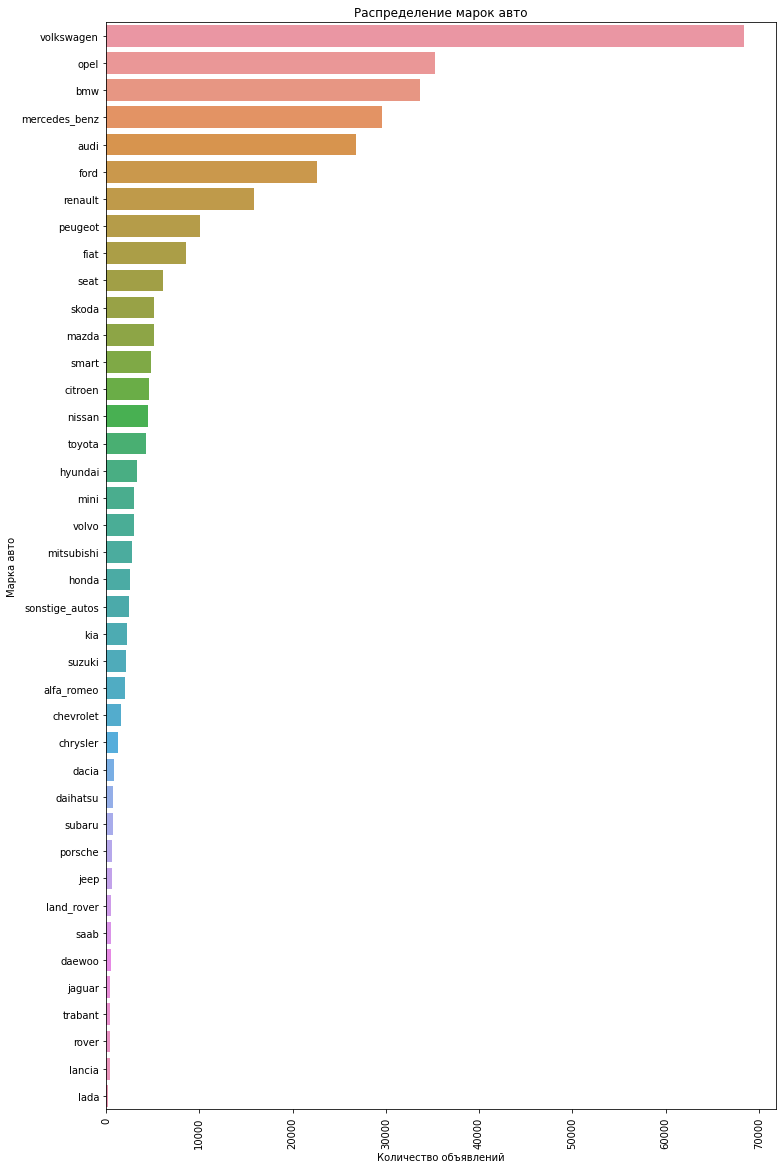

In [51]:
plt.figure(figsize=(12, 20))

sns.countplot(data=data, y='brand', order = data['brand'].value_counts().index)

plt.title('Распределение марок авто')
plt.ylabel('Марка авто')
plt.xlabel('Количество объявлений')
plt.xticks(rotation= 90)

plt.show()

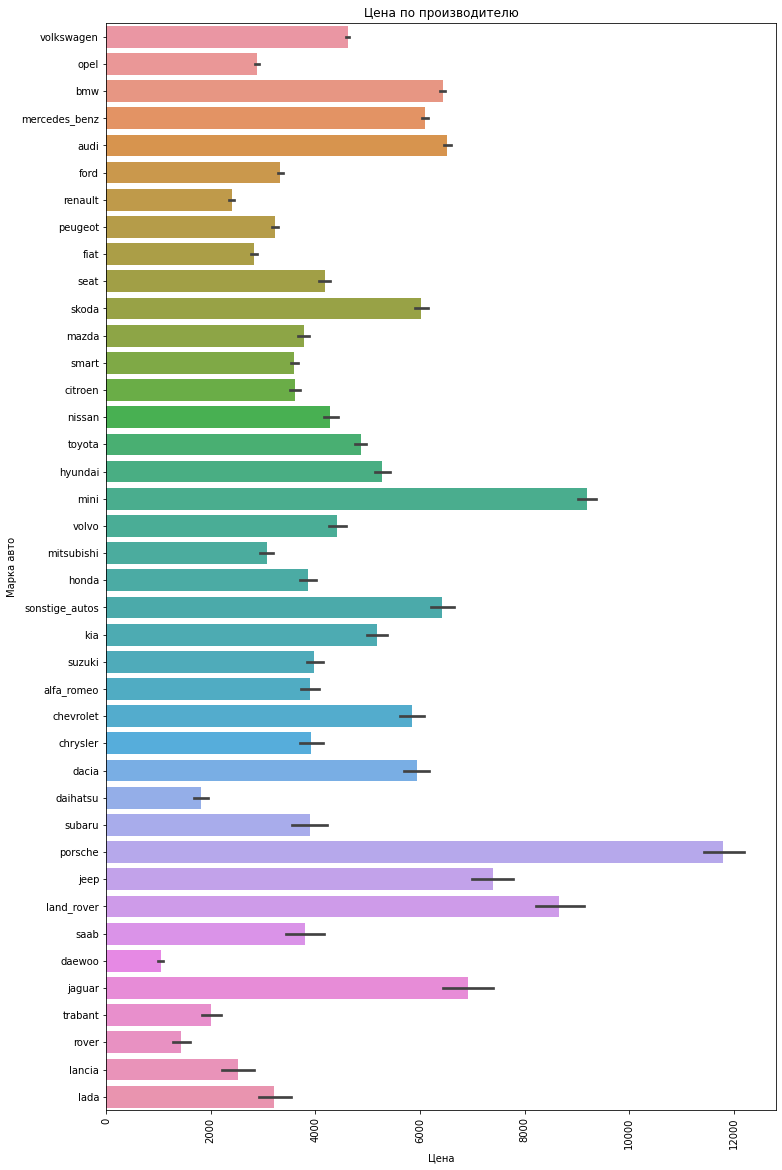

In [52]:
plt.figure(figsize=(12, 20))

sns.barplot(data=data, y='brand', x='price', order=data['brand'].value_counts().index)
plt.title('Цена по производителю')
plt.xticks(rotation= 90)


plt.xlabel('Цена', fontsize = 10)
plt.ylabel('Марка авто', fontsize = 10)

plt.show()

Самы популярные авто - немецкие, причем VW впереди планеты всей. По цене очевидно выше премиальный сегмент - Порше, Мини, Ягурар и Ленд Ровер

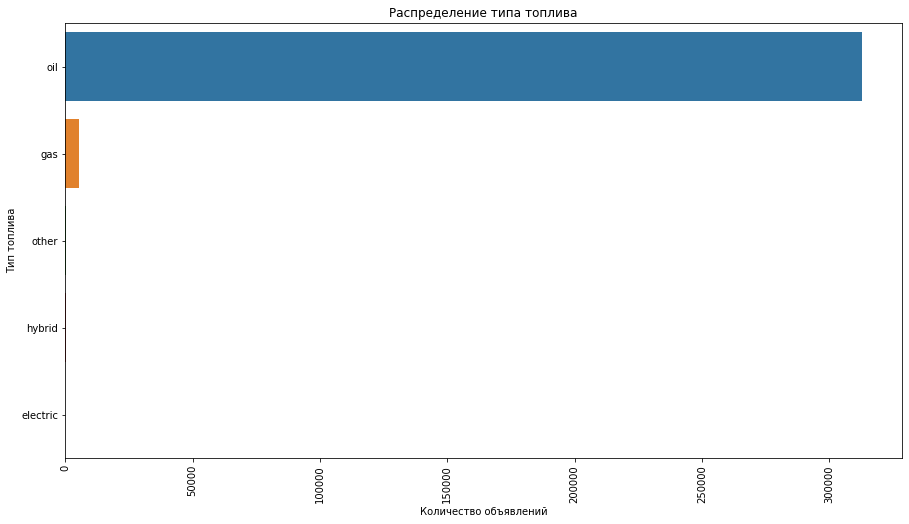

In [53]:
plt.figure(figsize=(15, 8))
sns.countplot(data=data, y='fuel_type', )

plt.title('Распределение типа топлива')
plt.ylabel('Тип топлива')
plt.xlabel('Количество объявлений')
plt.xticks(rotation= 90)

plt.show()

In [54]:
data.fuel_type.value_counts(normalize=True)

oil         0.981687
gas         0.016907
hybrid      0.000684
other       0.000458
electric    0.000264
Name: fuel_type, dtype: float64

98% авто - на бензине, 1,5% - на газе, электромобилей совсем-совсем мало

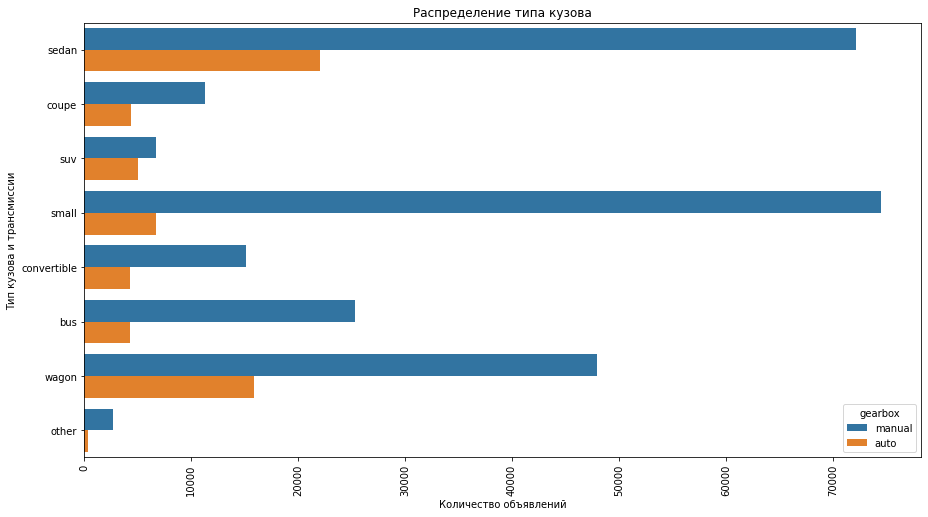

In [55]:
plt.figure(figsize=(15, 8))
sns.countplot(data=data, y='vehicle_type', hue='gearbox')

plt.title('Распределение типа кузова')
plt.ylabel('Тип кузова и трансмиссии')
plt.xlabel('Количество объявлений')
plt.xticks(rotation= 90)

plt.show()

Седаны поулярнее маленьких машинок, а автобусы - кабриолетов. Странно, что SUV-сегмент так мал.

Механическая коробка передач популярнее в любом сегменте.

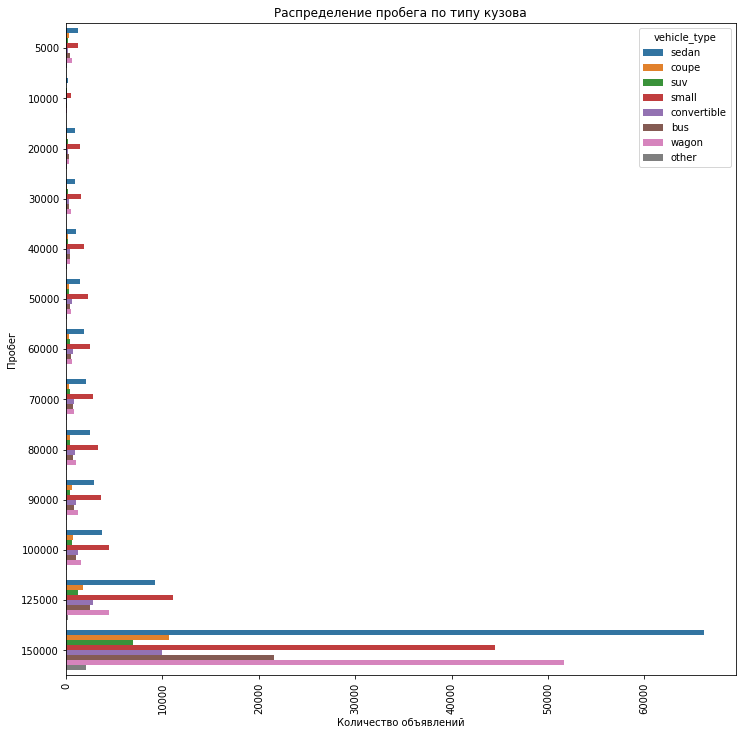

In [56]:
plt.figure(figsize=(12, 12))
sns.countplot(data=data, y='kilometer', hue='vehicle_type')

plt.title('Распределение пробега по типу кузова')
plt.ylabel('Пробег')
plt.xlabel('Количество объявлений')
plt.xticks(rotation= 90)

plt.show()

В датасете много объявлений о продаже машин с пробегами ~150 000 км. В лидерах - седнаны и универсалы.

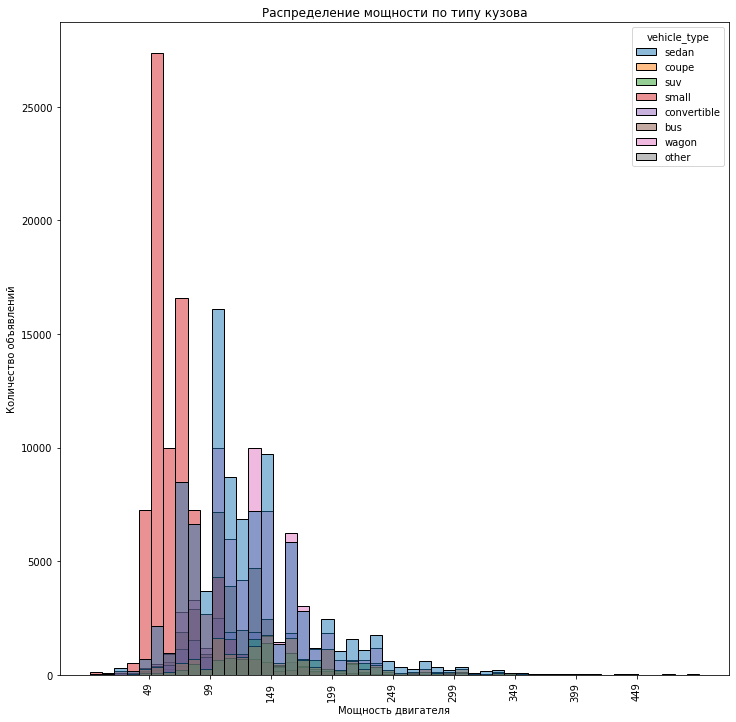

In [57]:
plt.figure(figsize=(12, 12))
sns.histplot(data=data, x='power', hue='vehicle_type', bins = 50).set(xticks=np.arange(49,451,50))

plt.title('Распределение мощности по типу кузова')
plt.xlabel('Мощность двигателя')
#plt.xlim(50, 500)
plt.ylabel('Количество объявлений')
plt.xticks(rotation= 90)


plt.show()

Малой мощностью двигателя отличаются маленькие машинки (до 100), далее пальма первенства уходит к седанам

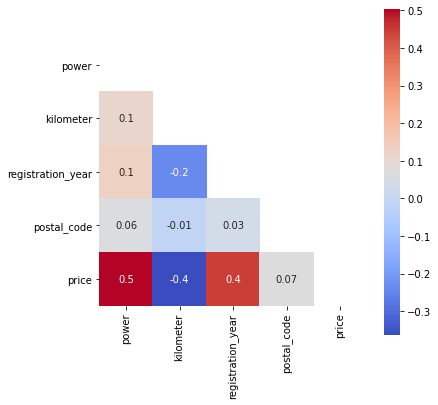

In [58]:
plt.figure(figsize=(6, 6))


sns.heatmap(
    data.select_dtypes(include=['int32', 'int64', 'float64']).corr(), 
    annot=True, 
    fmt='.1g',
    #vmin=-1, vmax=1, center= 0,
    cmap= 'coolwarm', square=True,
    mask=np.triu(data.select_dtypes(include=['int32', 'int64', 'float64']).corr())
)
plt.show()

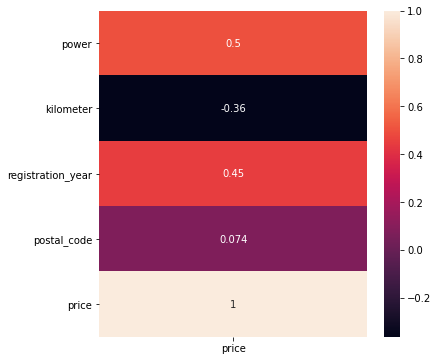

In [59]:
plt.figure(figsize=(6, 6))

sns.heatmap(data.select_dtypes(include=['int32', 'int64', 'float64']).corr()[['price']], annot = True)
plt.show()

Из матрицы корреляции видно, что цена прямо пропорциональна мощности и году регистрации и обратно пропорциональна пробегу.

In [60]:
# Добавим синтетические признаки


data['lifetime'] = (data['last_seen'] - data['date_created']).dt.days.astype('int')

In [61]:
# Будем считать, что последний просмотр есть дата продажи.

data['sell_year'] = data.last_seen.dt.year
data['sell_week'] = data.last_seen.dt.isocalendar().week
data['sell_day'] = data.last_seen.dt.day


In [62]:
data['sell_year'].unique()

# Мимо :(


array([2016], dtype=int64)

In [63]:

data = data.drop('sell_year', axis=1)

In [64]:
# На всякий - бакап
data_prepocessing = data

## Краткий вывод

Даныые загружены и просмотрены. Обнаружены проблемы в виде пропусков, неадекватных значений. 

Пропуски заполнены по наиболее частому (моде) в колонках с типом топлива, коробки передач и типа кузова.

Удалены неинформативные столбцы.

Унифицирован тип топлива.

## Обучение моделей

Подготовим выборки для обучения моделей.
Попробуем разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

In [66]:
data

,date_created,date_crawled,last_seen,brand,model,vehicle_type,fuel_type,gearbox,power,kilometer,registration_year,repaired,postal_code,price,lifetime,sell_week,sell_day
0,2016-03-24,2016-03-24,2016-04-07,volkswagen,golf,sedan,oil,manual,98.0,150000,1993,no,70435,480,14,14,7
1,2016-03-24,2016-03-24,2016-04-07,audi,other,coupe,oil,manual,190.0,125000,2011,yes,66954,18300,14,14,7
2,2016-03-14,2016-03-15,2016-04-06,jeep,grand,suv,oil,auto,163.0,125000,2004,no,90480,9800,23,14,6
3,2016-03-17,2016-03-18,2016-03-18,volkswagen,golf,small,oil,manual,75.0,150000,2001,no,91074,1500,1,11,18
4,2016-03-31,2016-04-01,2016-04-06,skoda,fabia,small,oil,manual,69.0,90000,2008,no,60437,3600,6,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27,2016-03-28,2016-03-29,opel,zafira,bus,oil,manual,120.0,150000,2000,no,26624,1150,2,13,29
354365,2016-03-14,2016-03-15,2016-04-06,sonstige_autos,other,sedan,oil,manual,50.0,20000,2005,no,39576,2200,23,14,6
354366,2016-03-05,2016-03-06,2016-03-12,smart,fortwo,convertible,oil,auto,101.0,125000,2000,no,26135,1199,7,10,12
354367,2016-03-19,2016-03-20,2016-04-07,volkswagen,transporter,bus,oil,manual,102.0,150000,1996,no,87439,9200,19,14,7


In [67]:
# Удалим первые столбца с датами - date_crawled неинформативен, остальные два использовали для синтетических признаков
data.drop(['date_created', 'date_crawled', 'last_seen', 'postal_code'], axis=1, inplace=True)



In [68]:
features = data.drop('price', axis=1)
target = data.price

In [69]:
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    train_size=.8, 
    random_state=RS, 
    )

print(f'features_train: {features_train.shape}')

print(f'features_test: {features_test.shape}')

print(f'target_train: {target_train.shape}')

print(f'target_test: {target_test.shape}')

features_train: (254992, 12)
features_test: (63749, 12)
target_train: (254992,)
target_test: (63749,)


In [70]:
# Закодируем категориальные переменные

categories = ['brand', 'model', 'vehicle_type', 'fuel_type', 'gearbox', 'repaired']

ohe_categories = ['vehicle_type', 'fuel_type', 'gearbox', 'repaired']
me_categories = ['brand', 'model']

numeric = ['power', 'kilometer', 'registration_year', 'lifetime', 'sell_week', 'sell_day']

enc = OneHotEncoder(drop='first', handle_unknown='ignore')

features_train_ohe = pd.DataFrame(enc.fit_transform(features_train[ohe_categories]).toarray(),  \
    columns=enc.get_feature_names_out(ohe_categories), index=features_train.index)
features_test_ohe = pd.DataFrame(enc.transform(features_test[ohe_categories]).toarray(), \
    columns=enc.get_feature_names_out(ohe_categories), index=features_test.index)


features_train_ohe = pd.concat((features_train[numeric], features_train[me_categories], features_train_ohe), axis=1)
features_test_ohe = pd.concat((features_test[numeric], features_test[me_categories], features_test_ohe), axis=1)

In [71]:

from category_encoders import MEstimateEncoder

me_enc = MEstimateEncoder(cols=me_categories)

features_train_encoded = me_enc.fit_transform(features_train_ohe, target_train)
features_test_encoded = me_enc.transform(features_test_ohe, target_test)


In [72]:
print(features_test_encoded.shape)
print(features_train_encoded.shape)

(63749, 21)
(254992, 21)


In [73]:
features_train_encoded

,power,kilometer,registration_year,lifetime,sell_week,sell_day,brand,model,vehicle_type_convertible,vehicle_type_coupe,...,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,fuel_type_gas,fuel_type_hybrid,fuel_type_oil,fuel_type_other,gearbox_manual,repaired_yes
199511,150.0,150000,2004,7,13,2,6514.911848,6263.692180,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
338751,80.0,150000,2008,25,14,6,6075.866621,6871.324443,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
327668,131.0,150000,2001,0,13,30,4624.150274,4651.358120,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
296787,224.0,150000,2005,13,14,7,6514.911848,6663.005158,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
169601,163.0,150000,2006,9,11,18,6449.554831,5218.455890,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215663,163.0,150000,2002,30,14,6,6100.054845,5593.587653,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
205370,231.0,150000,2004,13,14,7,6449.554831,6590.844755,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1918,50.0,125000,2000,3,10,13,4624.150274,1440.872454,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
54306,110.0,20000,2014,8,11,17,6514.911848,6263.692180,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [74]:
# Масштабируем
#features_test_encoded[features_train_encoded.columns]
scaler = StandardScaler()

features_train_encoded[numeric] = scaler.fit_transform(features_train_encoded[numeric])
features_test_encoded[numeric] = scaler.transform(features_test_encoded[numeric])

In [75]:
print(features_test_encoded.columns.shape)
print(features_train_encoded.columns.shape)

(21,)
(21,)


In [76]:
rf_model = RandomForestRegressor(random_state=RS)

start_time = time.time()

rf_model.fit(features_train_encoded, target_train)

rf_learning_time = time.time() - start_time


rf_predictions = rf_model.predict(features_test_encoded)

print('RMSE', np.sqrt(mean_squared_error(target_test, rf_predictions)))

RMSE 1601.7296406953833


In [77]:
%%time
start_time = time.time()
    

# RandomForest
rf_parameters = {'max_depth': [8, 16],
              'n_estimators': [50, 150],
              
              }

rf_model = RandomForestRegressor(random_state=RS)
rf_grid = GridSearchCV(rf_model, rf_parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

rf_grid.fit(features_train_encoded, target_train)

rf_grid_time = time.time() - start_time


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................max_depth=8, n_estimators=50; total time=  14.0s
[CV] END .......................max_depth=8, n_estimators=50; total time=  13.9s
[CV] END .......................max_depth=8, n_estimators=50; total time=  13.9s
[CV] END .......................max_depth=8, n_estimators=50; total time=  13.9s
[CV] END .......................max_depth=8, n_estimators=50; total time=  13.9s
[CV] END ......................max_depth=8, n_estimators=150; total time=  41.8s
[CV] END ......................max_depth=8, n_estimators=150; total time=  41.8s
[CV] END ......................max_depth=8, n_estimators=150; total time=  41.8s
[CV] END ......................max_depth=8, n_estimators=150; total time=  42.6s
[CV] END ......................max_depth=8, n_estimators=150; total time=  43.2s
[CV] END ......................max_depth=16, n_estimators=50; total time=  27.1s
[CV] END ......................max_depth=16, n_es

In [78]:
rf_grid.best_params_

{'max_depth': 16, 'n_estimators': 150}

In [79]:
#rf_model = RandomForestRegressor(random_state=RS, **rf_grid.best_params_)

rf_model = rf_grid.best_estimator_

#rf_model.fit(features_train_encoded, target_train)

#rf_predictions = rf_model.predict(features_test_encoded)

#print('RMSE', np.sqrt(mean_squared_error(target_test, rf_predictions)))

rf_rmse = rf_grid.best_score_

print('Best RMSE:', rf_rmse)

# Здесь отрицательный RMSE из-за того, что scoring='neg_root_mean_squared_error'? Берем по модулю?
rf_rmse = abs(rf_rmse)



Best RMSE: -1639.3580378055908


In [80]:
lgbm_model = LGBMRegressor(random_state=RS)

start_time = time.time()

lgbm_model.fit(features_train_encoded, target_train)

lgbm_learning_time = time.time() - start_time

lgbm_predictions = lgbm_model.predict(features_test_encoded)

print('RMSE', np.sqrt(mean_squared_error(target_test, lgbm_predictions)))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 254992, number of used features: 21
[LightGBM] [Info] Start training from score 4646.213034
RMSE 1665.3656684543141


In [81]:
%%time
start_time = time.time()
# LGBM
lgbm_parameters = {'max_depth': [8, 16, 32],
              'n_estimators': [50, 100, 150],
              'num_leaves': [100, 150]
              }

lgbm_model = LGBMRegressor(random_state=RS)
lgbm_grid = GridSearchCV(lgbm_model, lgbm_parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=1)

lgbm_grid.fit(features_train_encoded, target_train)

lgbm_grid_time = time.time() - start_time


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 203993, number of used features: 21
[LightGBM] [Info] Start training from score 4642.581608
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 203993, number of used features: 21
[LightGBM] [Info] Start training from score 4647.374263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006246 seconds.
You can 

In [82]:
lgbm_grid.best_params_

{'max_depth': 32, 'n_estimators': 150, 'num_leaves': 150}

In [99]:
lgbm_model = lgbm_grid.best_estimator_

lgbm_rmse = abs(lgbm_grid.best_score_)

print('RMSE', lgbm_rmse)

RMSE 1573.846453932376


In [97]:
start_time = time.time()
cbr_model = CatBoostRegressor(random_state=RS)

cbr_model.fit(features_train_encoded, target_train)

cbr_learning_time = time.time() - start_time

cbr_predictions = cbr_model.predict(features_test_encoded)

print('RMSE', np.sqrt(mean_squared_error(target_test, cbr_predictions)))

Learning rate set to 0.098268
0:	learn: 4254.0699454	total: 42.8ms	remaining: 42.7s
1:	learn: 3995.4071666	total: 60.7ms	remaining: 30.3s
2:	learn: 3768.7954233	total: 75.5ms	remaining: 25.1s
3:	learn: 3572.5480814	total: 92.6ms	remaining: 23.1s
4:	learn: 3390.4919685	total: 108ms	remaining: 21.5s
5:	learn: 3237.9774982	total: 125ms	remaining: 20.8s
6:	learn: 3095.3361628	total: 138ms	remaining: 19.6s
7:	learn: 2969.3296554	total: 152ms	remaining: 18.8s
8:	learn: 2862.3355880	total: 164ms	remaining: 18.1s
9:	learn: 2766.6692130	total: 177ms	remaining: 17.5s
10:	learn: 2681.3196864	total: 189ms	remaining: 17s
11:	learn: 2605.2484992	total: 203ms	remaining: 16.7s
12:	learn: 2538.6329707	total: 217ms	remaining: 16.5s
13:	learn: 2473.3820413	total: 233ms	remaining: 16.4s
14:	learn: 2420.3362689	total: 248ms	remaining: 16.3s
15:	learn: 2373.2504581	total: 265ms	remaining: 16.3s
16:	learn: 2326.8519496	total: 281ms	remaining: 16.2s
17:	learn: 2288.2453088	total: 295ms	remaining: 16.1s
18:	le

In [85]:
cbr_features_train = features_train
cbr_features_test = features_test

cbr_features_train[numeric] = features_train[numeric].astype('float64')
cbr_features_test[numeric] = features_test[numeric].astype('float64')

In [86]:
cbr_model = CatBoostRegressor(loss_function='RMSE', random_seed=RS)

cbr_train = Pool(cbr_features_train, target_train, cat_features=categories) 
cbr_test = Pool(cbr_features_test, target_test, cat_features=categories)

cbr_parameters = {
        'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]
        }

start_time = time.time()

cbr_model.grid_search(cbr_parameters, cbr_train)

cbr_grid_time = time.time() - start_time

cbr_rmse = cbr_model.best_score_


0:	learn: 6349.0935500	test: 6371.0419112	best: 6371.0419112 (0)	total: 20.3ms	remaining: 2.01s
1:	learn: 6208.8132952	test: 6230.3331207	best: 6230.3331207 (1)	total: 40ms	remaining: 1.96s
2:	learn: 6073.8795812	test: 6094.8293165	best: 6094.8293165 (2)	total: 59.6ms	remaining: 1.93s
3:	learn: 5943.7608024	test: 5964.2897864	best: 5964.2897864 (3)	total: 76.9ms	remaining: 1.84s
4:	learn: 5818.5346666	test: 5838.5294304	best: 5838.5294304 (4)	total: 96.8ms	remaining: 1.84s
5:	learn: 5698.3532654	test: 5717.8255439	best: 5717.8255439 (5)	total: 117ms	remaining: 1.83s
6:	learn: 5582.4247994	test: 5601.7552359	best: 5601.7552359 (6)	total: 137ms	remaining: 1.81s
7:	learn: 5470.8540242	test: 5489.6543589	best: 5489.6543589 (7)	total: 155ms	remaining: 1.78s
8:	learn: 5362.2424777	test: 5380.5421373	best: 5380.5421373 (8)	total: 172ms	remaining: 1.74s
9:	learn: 5258.9468727	test: 5276.9741667	best: 5276.9741667 (9)	total: 190ms	remaining: 1.71s
10:	learn: 5158.2534941	test: 5175.6370269	best

In [95]:
cbr_rmse = cbr_model.best_score_['learn']['RMSE']

## Вывод

Данные подготовлены для машинного обучения, созданы обучающая и тестовая выборки.

Категориальные признаки закодированы с помощью OneHotEncoder и MEstimateEncoder, проведено масштабирование данных.

Обучены три модели - RandomForest, LightGBM и CatBoost. 

Каждой модели подобраны гиперпараметры с помощью GridSearch.

Рассчитаны значения метрики и замеряно время обучения.

## Анализ моделей

In [98]:
result_table = pd.DataFrame({
    'RandomForest': [rf_rmse, rf_learning_time, rf_grid_time], 
    'LGBM': [lgbm_rmse, lgbm_learning_time, lgbm_grid_time], 
    'CatBoost': [cbr_rmse, cbr_learning_time, cbr_grid_time]
    },
    index=['RMSE', 'Learning time', 'Grid time'])
result_table

,RandomForest,LGBM,CatBoost
RMSE,1639.358038,-1573.846454,1603.509272
Learning time,109.715194,0.725550,13.751586
Grid time,922.383048,80.268823,813.900389


Как видно из таблички, модель lightGBM работает заметно быстрее и точнее остальных обученных моделей.